In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

### Loading the Fashion MNIST dataset 

In [2]:
fmnist = FashionMNIST(root = 'data', train = True, download = True, transform = Compose([ToTensor(),Normalize(mean=(0.5,), std = (0.5,))]))

In [3]:
#selecting the image from dataset, img represents image data, label represents 0 or 1.
img, label = fmnist[0]
print('label ',(label))
#Selecting a subset of image pixels from rows 10 to 14(inclusive), and columns 10 to 14(inclusive)
print(img[:,10:15, 10:15])
torch.min(img),torch.max(img)

label  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [4]:
#Denormalizing the image using the below function and clamp restricts the image to be in the mentioned pixel value(0,1) instead of (-1,1)
def denorm(x):
    out = (x+1)/2
    return out.clamp(0,1)

label  9


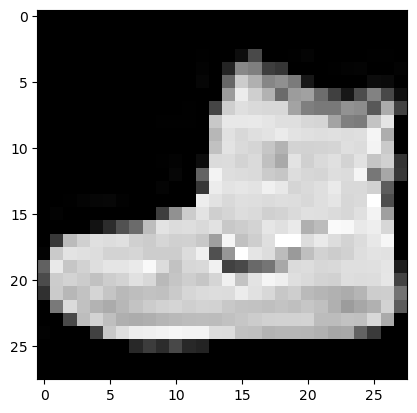

In [5]:
#selecting a image of fmnist[0] and showing the image.
import matplotlib.pyplot as plt
%matplotlib inline

denorm_img = denorm(img)
plt.imshow(denorm_img[0],cmap='gray')
print('label ', label)



In [6]:
#Creating a dataloader for fashionmnist dataset for batchsize = 100.
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fmnist,batch_size,shuffle = True)

first_batch
torch.Size([100, 1, 28, 28])
tensor([0, 1, 2, 5, 7, 2, 5, 2, 1, 3, 3, 6, 6, 3, 5, 2, 3, 8, 3, 5, 5, 6, 9, 1,
        9, 6, 5, 8, 4, 2, 1, 8, 1, 0, 9, 5, 1, 0, 1, 6, 2, 2, 5, 5, 6, 1, 5, 2,
        5, 0, 5, 4, 9, 1, 0, 2, 6, 6, 1, 3, 5, 9, 9, 9, 3, 0, 1, 3, 8, 9, 4, 9,
        8, 2, 5, 2, 0, 5, 5, 0, 9, 0, 2, 0, 4, 3, 2, 6, 7, 0, 0, 0, 3, 9, 7, 5,
        5, 6, 3, 0])


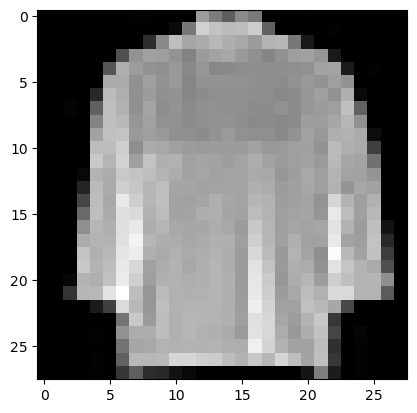

In [7]:
for image_batch, label_batch in data_loader:
    print('first_batch')
    print(image_batch.shape)
    plt.imshow(image_batch[0][0], cmap = 'gray')
    print(label_batch)
    break

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. While we can use a CNN for the discriminator, we'll use a simple feedforward network with 3 linear layers to keep things since. We'll treat each 28x28 image as a vector of size 784.

In [10]:
input_image_size = 784
hidden_size = 256

In [11]:
import torch.nn as nn

discriminator = nn.Sequential(
        nn.Linear(input_image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size,1),
        nn.Sigmoid())


We use the Leaky ReLU and sigmoid activation for the discriminator.

Just like any other binary classification model, the output of the discriminator is a single number between 0 and 1, which can be interpreted as the probability of the input image being fake i.e. generated.

Moving the discriminator model to the chosen device.

In [12]:
discriminator.to(device);

### Generator Network

In [13]:
input_generator = 64

In [14]:
#Generator having four linear layers, ReLU and Tanh activation functions.
generator = nn.Sequential(
    nn.Linear(input_generator,hidden_size),
    nn.ReLU(inplace = True),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(inplace = True),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(inplace = True),
    nn.Linear(hidden_size, input_image_size),
    nn.Tanh()
)

 Using the TanH activation function for the output layer of the generator.

"The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling.

Since the outputs of the TanH activation lie in the range [-1,1], we have applied the same transformation to the images in the training dataset. Let's generate an output vector using the generator and view it as an image by transforming and denormalizing the output.

In [15]:
#Detach is used when we dont want to flow back the gradients 
y = generator(torch.randn(2, input_generator))
gen_imgs = denorm(y.reshape((-1,28,28)).detach())

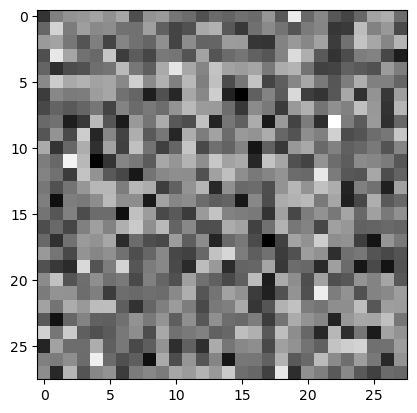

In [16]:
plt.imshow(gen_imgs[0], cmap = 'gray')

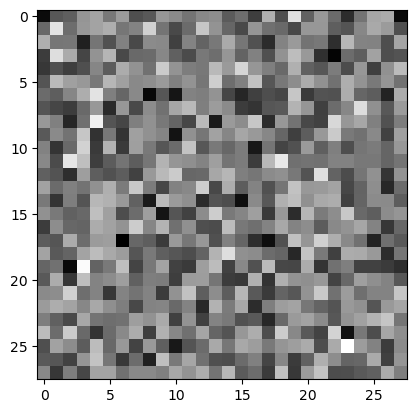

In [17]:
plt.imshow(gen_imgs[1], cmap = 'gray')

As one might expect, the output from the generator is basically random noise. Let's define a helper function which can save a batch of outputs from the generator to a file.

Moving the generator to the chosen device.

In [18]:
generator.to(device);

### Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

In [19]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr = 0.0002)

Let's define helper functions to reset gradients and train the discriminator.

In [20]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = discriminator(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, input_generator).to(device)
    fake_images = generator(z)
    outputs = discriminator(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Here are the steps involved in training the discriminator.

We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated.

We first pass a batch of real images, and compute the loss, setting the target labels to 1.

Then, we generate a batch of fake images using the generator, pass them into the discriminator, and compute the loss, setting the target labels to 0.

Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (d_optimizer only affects the D.parameters())

### Generator Training

Generator Training
Since the outputs of the generator are images, it's not obvious how we can train the generator. This is where we employ a rather elegant trick, which is to use the discriminator as a part of the loss function. Here's how it works:

We generate a batch of images using the generator, pass the into the discriminator.

We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images.

Here's what this looks like in code.

In [21]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

In [22]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, input_generator).to(device)
    fake_images = generator(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(discriminator(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

## Training the Model

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model

In [23]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Let's save a batch of real images that we can use for visual comparision while looking at the generated images.



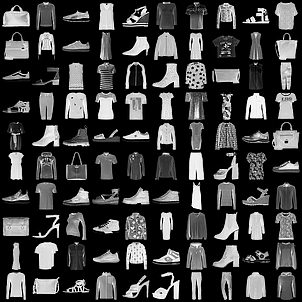

In [24]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

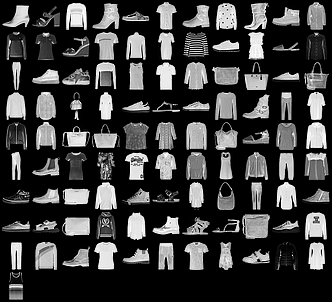

In [25]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=11)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


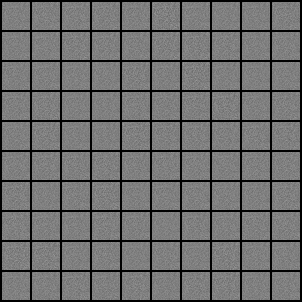

In [26]:
sample_vectors = torch.randn(batch_size, input_generator).to(device)

def save_fake_images(index):
    fake_images = generator(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

We are now ready to train the model. In each epoch, we train the discriminator first, and then the generator. The training might take a while if you're not using a GPU.

In [27]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0825, g_loss: 4.1876, D(x): 0.98, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.0448, g_loss: 9.9643, D(x): 0.98, D(G(z)): 0.02
Epoch [0/300], Step [600/600], d_loss: 0.1275, g_loss: 5.8200, D(x): 0.97, D(G(z)): 0.04
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0948, g_loss: 6.4826, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.0527, g_loss: 5.6011, D(x): 0.98, D(G(z)): 0.02
Epoch [1/300], Step [600/600], d_loss: 0.0702, g_loss: 6.9353, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0667, g_loss: 7.3762, D(x): 0.98, D(G(z)): 0.00
Epoch [2/300], Step [400/600], d_loss: 0.0055, g_loss: 12.0699, D(x): 1.00, D(G(z)): 0.00
Epoch [2/300], Step [600/600], d_loss: 0.0914, g_loss: 4.6477, D(x): 0.99, D(G(z)): 0.07
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1364, g_loss: 3.9434, D(x): 0.97, D(G(z)): 0.08
Epoch [3/300], Step [400/

Epoch [27/300], Step [600/600], d_loss: 0.3697, g_loss: 3.9312, D(x): 0.87, D(G(z)): 0.10
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.5213, g_loss: 3.2186, D(x): 0.83, D(G(z)): 0.12
Epoch [28/300], Step [400/600], d_loss: 0.6302, g_loss: 3.4283, D(x): 0.85, D(G(z)): 0.19
Epoch [28/300], Step [600/600], d_loss: 0.3217, g_loss: 3.4171, D(x): 0.91, D(G(z)): 0.14
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.5586, g_loss: 2.8899, D(x): 0.78, D(G(z)): 0.10
Epoch [29/300], Step [400/600], d_loss: 0.7392, g_loss: 2.5771, D(x): 0.84, D(G(z)): 0.17
Epoch [29/300], Step [600/600], d_loss: 0.4396, g_loss: 3.5996, D(x): 0.87, D(G(z)): 0.14
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.3495, g_loss: 2.6273, D(x): 0.91, D(G(z)): 0.16
Epoch [30/300], Step [400/600], d_loss: 0.3648, g_loss: 3.4025, D(x): 0.89, D(G(z)): 0.08
Epoch [30/300], Step [600/600], d_loss: 0.4798, g_loss: 2.4839, D(x): 0.84, D(G(z)): 0.13
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.6755, g_loss: 2.7030, D(x): 0.79, D(G(z)): 0.20
Epoch [55/300], Step [600/600], d_loss: 0.8427, g_loss: 2.0221, D(x): 0.73, D(G(z)): 0.20
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.7858, g_loss: 1.9890, D(x): 0.79, D(G(z)): 0.25
Epoch [56/300], Step [400/600], d_loss: 0.5832, g_loss: 1.8635, D(x): 0.85, D(G(z)): 0.25
Epoch [56/300], Step [600/600], d_loss: 0.8272, g_loss: 1.6770, D(x): 0.81, D(G(z)): 0.33
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.5978, g_loss: 2.2070, D(x): 0.83, D(G(z)): 0.22
Epoch [57/300], Step [400/600], d_loss: 0.8312, g_loss: 1.9978, D(x): 0.78, D(G(z)): 0.27
Epoch [57/300], Step [600/600], d_loss: 0.6496, g_loss: 2.2198, D(x): 0.82, D(G(z)): 0.18
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6058, g_loss: 2.0530, D(x): 0.80, D(G(z)): 0.20
Epoch [58/300], Step [400/600], d_loss: 0.6829, g_loss: 2.0585, D(x): 0.79, D(G(z)): 0.22
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.7225, g_loss: 1.8924, D(x): 0.72, D(G(z)): 0.22
Epoch [83/300], Step [400/600], d_loss: 0.8417, g_loss: 1.5739, D(x): 0.70, D(G(z)): 0.26
Epoch [83/300], Step [600/600], d_loss: 0.6726, g_loss: 1.7077, D(x): 0.84, D(G(z)): 0.30
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.7063, g_loss: 1.9603, D(x): 0.77, D(G(z)): 0.25
Epoch [84/300], Step [400/600], d_loss: 0.8837, g_loss: 1.8389, D(x): 0.77, D(G(z)): 0.33
Epoch [84/300], Step [600/600], d_loss: 0.9919, g_loss: 1.7414, D(x): 0.65, D(G(z)): 0.24
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.7546, g_loss: 2.2657, D(x): 0.74, D(G(z)): 0.25
Epoch [85/300], Step [400/600], d_loss: 0.9212, g_loss: 1.5378, D(x): 0.70, D(G(z)): 0.29
Epoch [85/300], Step [600/600], d_loss: 0.8283, g_loss: 1.8675, D(x): 0.71, D(G(z)): 0.25
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 1.0732, g_loss: 1.8698, D(x): 0.63, D(G(z)): 0.27
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 1.0481, g_loss: 1.4544, D(x): 0.67, D(G(z)): 0.33
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 1.0684, g_loss: 1.9370, D(x): 0.64, D(G(z)): 0.30
Epoch [111/300], Step [400/600], d_loss: 0.7955, g_loss: 1.5830, D(x): 0.74, D(G(z)): 0.29
Epoch [111/300], Step [600/600], d_loss: 1.2005, g_loss: 1.2445, D(x): 0.61, D(G(z)): 0.39
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.8173, g_loss: 1.4177, D(x): 0.70, D(G(z)): 0.28
Epoch [112/300], Step [400/600], d_loss: 0.7274, g_loss: 1.6871, D(x): 0.71, D(G(z)): 0.24
Epoch [112/300], Step [600/600], d_loss: 0.9742, g_loss: 1.3840, D(x): 0.62, D(G(z)): 0.28
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.9641, g_loss: 1.7503, D(x): 0.66, D(G(z)): 0.33
Epoch [113/300], Step [400/600], d_loss: 1.2945, g_loss: 1.2588, D(x): 0.55, D(G(z)): 0.33
Epoch [113/300], Step [600/600], d_loss: 1.0319, g_loss: 1.3029, D(x): 0.69, D(G(z)): 0.37
Saving

Epoch [138/300], Step [200/600], d_loss: 1.0040, g_loss: 1.2191, D(x): 0.64, D(G(z)): 0.34
Epoch [138/300], Step [400/600], d_loss: 1.1219, g_loss: 1.0427, D(x): 0.65, D(G(z)): 0.40
Epoch [138/300], Step [600/600], d_loss: 1.1265, g_loss: 1.3626, D(x): 0.66, D(G(z)): 0.39
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 1.0459, g_loss: 1.2220, D(x): 0.65, D(G(z)): 0.39
Epoch [139/300], Step [400/600], d_loss: 1.0642, g_loss: 1.4343, D(x): 0.60, D(G(z)): 0.32
Epoch [139/300], Step [600/600], d_loss: 1.1288, g_loss: 1.3098, D(x): 0.62, D(G(z)): 0.35
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.8940, g_loss: 1.5768, D(x): 0.64, D(G(z)): 0.28
Epoch [140/300], Step [400/600], d_loss: 0.9548, g_loss: 1.0995, D(x): 0.69, D(G(z)): 0.37
Epoch [140/300], Step [600/600], d_loss: 0.8552, g_loss: 1.5088, D(x): 0.67, D(G(z)): 0.27
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.8694, g_loss: 1.6005, D(x): 0.71, D(G(z)): 0.32
Epoch 

Epoch [165/300], Step [400/600], d_loss: 1.6169, g_loss: 1.2549, D(x): 0.46, D(G(z)): 0.39
Epoch [165/300], Step [600/600], d_loss: 0.9869, g_loss: 1.3288, D(x): 0.68, D(G(z)): 0.37
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.8627, g_loss: 1.4120, D(x): 0.73, D(G(z)): 0.32
Epoch [166/300], Step [400/600], d_loss: 1.1146, g_loss: 1.2534, D(x): 0.70, D(G(z)): 0.42
Epoch [166/300], Step [600/600], d_loss: 1.5613, g_loss: 1.0871, D(x): 0.49, D(G(z)): 0.43
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 1.1652, g_loss: 1.1453, D(x): 0.61, D(G(z)): 0.38
Epoch [167/300], Step [400/600], d_loss: 0.7480, g_loss: 1.7231, D(x): 0.69, D(G(z)): 0.23
Epoch [167/300], Step [600/600], d_loss: 0.8863, g_loss: 1.3521, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 1.2406, g_loss: 1.1651, D(x): 0.56, D(G(z)): 0.36
Epoch [168/300], Step [400/600], d_loss: 0.8517, g_loss: 1.4537, D(x): 0.69, D(G(z)): 0.30
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.9272, g_loss: 1.5756, D(x): 0.69, D(G(z)): 0.31
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.6909, g_loss: 1.6697, D(x): 0.75, D(G(z)): 0.25
Epoch [193/300], Step [400/600], d_loss: 1.2617, g_loss: 1.3392, D(x): 0.65, D(G(z)): 0.44
Epoch [193/300], Step [600/600], d_loss: 1.0402, g_loss: 1.4171, D(x): 0.65, D(G(z)): 0.35
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 1.1230, g_loss: 1.2477, D(x): 0.60, D(G(z)): 0.32
Epoch [194/300], Step [400/600], d_loss: 0.9693, g_loss: 1.4871, D(x): 0.68, D(G(z)): 0.35
Epoch [194/300], Step [600/600], d_loss: 0.8097, g_loss: 1.4955, D(x): 0.71, D(G(z)): 0.30
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 1.0618, g_loss: 1.4457, D(x): 0.64, D(G(z)): 0.32
Epoch [195/300], Step [400/600], d_loss: 1.2214, g_loss: 1.5441, D(x): 0.67, D(G(z)): 0.41
Epoch [195/300], Step [600/600], d_loss: 0.7754, g_loss: 1.5007, D(x): 0.74, D(G(z)): 0.28
Saving

Epoch [220/300], Step [200/600], d_loss: 0.7937, g_loss: 1.5430, D(x): 0.68, D(G(z)): 0.25
Epoch [220/300], Step [400/600], d_loss: 0.8584, g_loss: 1.6945, D(x): 0.73, D(G(z)): 0.29
Epoch [220/300], Step [600/600], d_loss: 0.7571, g_loss: 1.4882, D(x): 0.74, D(G(z)): 0.28
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.7677, g_loss: 1.7178, D(x): 0.72, D(G(z)): 0.26
Epoch [221/300], Step [400/600], d_loss: 1.3259, g_loss: 1.1043, D(x): 0.58, D(G(z)): 0.41
Epoch [221/300], Step [600/600], d_loss: 0.8451, g_loss: 1.4722, D(x): 0.70, D(G(z)): 0.30
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.7290, g_loss: 1.5201, D(x): 0.76, D(G(z)): 0.31
Epoch [222/300], Step [400/600], d_loss: 0.9709, g_loss: 1.3001, D(x): 0.66, D(G(z)): 0.33
Epoch [222/300], Step [600/600], d_loss: 1.0417, g_loss: 1.3131, D(x): 0.61, D(G(z)): 0.31
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.7818, g_loss: 1.7418, D(x): 0.69, D(G(z)): 0.26
Epoch 

Epoch [247/300], Step [400/600], d_loss: 1.2131, g_loss: 1.4825, D(x): 0.59, D(G(z)): 0.35
Epoch [247/300], Step [600/600], d_loss: 1.0032, g_loss: 1.4262, D(x): 0.64, D(G(z)): 0.32
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.7927, g_loss: 1.6375, D(x): 0.74, D(G(z)): 0.31
Epoch [248/300], Step [400/600], d_loss: 0.7752, g_loss: 1.5203, D(x): 0.76, D(G(z)): 0.30
Epoch [248/300], Step [600/600], d_loss: 0.7736, g_loss: 1.7607, D(x): 0.72, D(G(z)): 0.27
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 0.7337, g_loss: 1.5767, D(x): 0.74, D(G(z)): 0.27
Epoch [249/300], Step [400/600], d_loss: 0.8167, g_loss: 1.6277, D(x): 0.71, D(G(z)): 0.27
Epoch [249/300], Step [600/600], d_loss: 0.8831, g_loss: 1.5042, D(x): 0.72, D(G(z)): 0.31
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.9514, g_loss: 1.3496, D(x): 0.66, D(G(z)): 0.30
Epoch [250/300], Step [400/600], d_loss: 1.3343, g_loss: 1.2430, D(x): 0.62, D(G(z)): 0.44
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.8468, g_loss: 1.4757, D(x): 0.73, D(G(z)): 0.32
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.9395, g_loss: 1.6023, D(x): 0.70, D(G(z)): 0.31
Epoch [275/300], Step [400/600], d_loss: 0.9983, g_loss: 1.5184, D(x): 0.65, D(G(z)): 0.31
Epoch [275/300], Step [600/600], d_loss: 0.9533, g_loss: 1.5788, D(x): 0.69, D(G(z)): 0.32
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.8169, g_loss: 1.4775, D(x): 0.71, D(G(z)): 0.29
Epoch [276/300], Step [400/600], d_loss: 1.1229, g_loss: 1.3250, D(x): 0.58, D(G(z)): 0.32
Epoch [276/300], Step [600/600], d_loss: 0.8813, g_loss: 1.7143, D(x): 0.70, D(G(z)): 0.29
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.8385, g_loss: 1.4136, D(x): 0.68, D(G(z)): 0.29
Epoch [277/300], Step [400/600], d_loss: 1.0332, g_loss: 1.4787, D(x): 0.64, D(G(z)): 0.31
Epoch [277/300], Step [600/600], d_loss: 0.9133, g_loss: 1.2883, D(x): 0.74, D(G(z)): 0.35
Saving

It iterates over three hundred number of epochs, trains the discriminator and generator networks alternatively using batched data from a data loader, and logs the discriminator and generator losses along with real and fake scores. As iterating over three hundred number of epochs it is taking about 30 minutes to complete all the epochs.

Here's how the generated images look, after the 10th, 50th, 100th and 300th epochs of training.

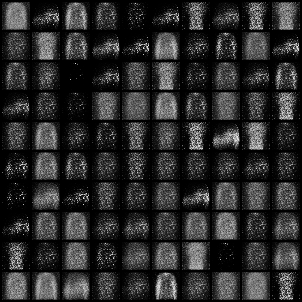

In [28]:
Image('./samples/fake_images-0010.png')

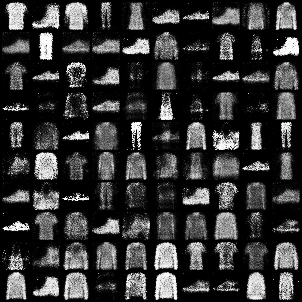

In [29]:
Image('./samples/fake_images-0050.png')

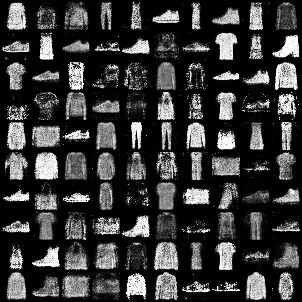

In [30]:
Image('./samples/fake_images-0100.png')

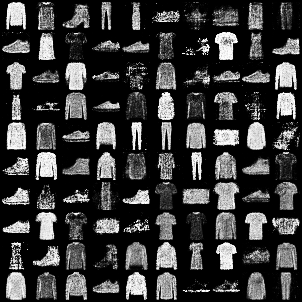

In [31]:
Image('./samples/fake_images-0300.png')

In [33]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


/Users/harikaboyina/Downloads/gans_training.avi

##### Saving the model weights

In [34]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'weights/generator_before_retraining_weight')
torch.save(discriminator.state_dict(), 'weights/discriminator_before_retraining_weight')

##### Loading the model using the saved weights.

In [35]:
import torch
gen_state_dict = torch.load('weights/generator_before_retraining_weight')
discriminator_state_dict = torch.load('weights/discriminator_before_retraining_weight')


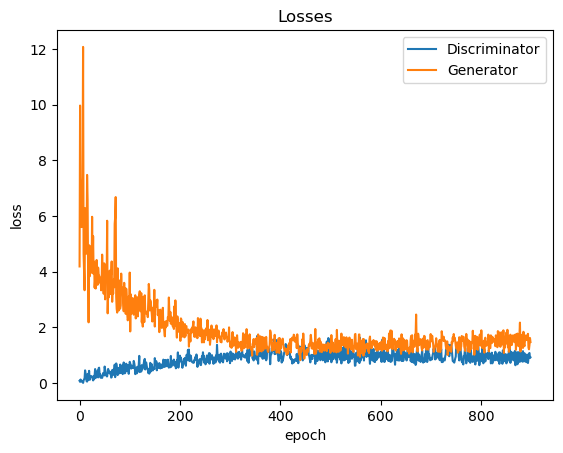

In [36]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

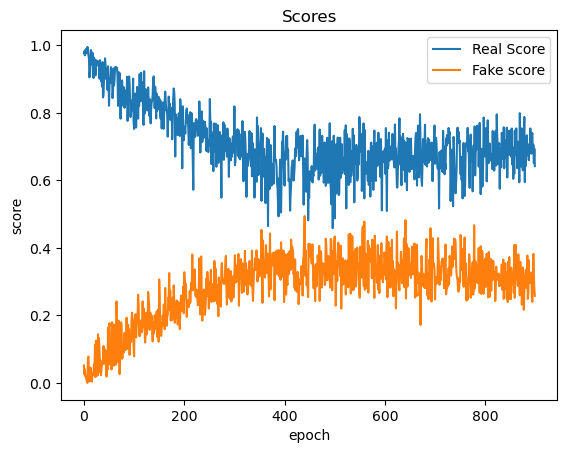

In [37]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

##### Re-training the GAN model

In [38]:
#Generator having four linear layers, ReLU and Tanh activation functions.
generator_new = nn.Sequential(
    nn.Linear(input_generator,hidden_size),
    nn.ReLU(inplace = True),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(inplace = True),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(inplace = True),
    nn.Linear(hidden_size, input_image_size),
    nn.Tanh()
)

generator_new.load_state_dict(gen_state_dict)

<All keys matched successfully>

In [39]:
import torch.nn as nn

discriminator_new = nn.Sequential(
        nn.Linear(input_image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size,1),
        nn.Sigmoid())

discriminator_new.load_state_dict(discriminator_state_dict)

<All keys matched successfully>

In [40]:
generator_new.to(device);

In [41]:
discriminator_new.to(device);

### Discriminator Training

In [42]:
criterion = nn.BCELoss()
d_optimizer_new = torch.optim.Adam(discriminator_new.parameters(), lr = 0.0005)

In [43]:
def reset_grad():
    d_optimizer_new.zero_grad()
    g_optimizer_new.zero_grad()

def train_discriminator_new(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = discriminator_new(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, input_generator).to(device)
    fake_images = generator_new(z)
    outputs = discriminator_new(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer_new.step()

    return d_loss, real_score, fake_score

### Generator Training

In [44]:
g_optimizer_new = torch.optim.Adam(generator_new.parameters(), lr=0.0005)

In [45]:
def train_generator_new():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, input_generator).to(device)
    fake_images = generator_new(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(discriminator_new(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer_new.step()
    return g_loss, fake_images

### Re-training the GAN model

In [46]:
%%time
num_epochs = 300
additional_epochs = 50
starting_epoch = num_epochs + 1

for epoch in range(starting_epoch, starting_epoch + additional_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator_new(images)
        g_loss, fake_images = train_generator_new()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs + additional_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)


Epoch [301/350], Step [200/600], d_loss: 1.0916, g_loss: 2.0937, D(x): 0.74, D(G(z)): 0.30
Epoch [301/350], Step [400/600], d_loss: 0.7342, g_loss: 2.2989, D(x): 0.78, D(G(z)): 0.23
Epoch [301/350], Step [600/600], d_loss: 0.8943, g_loss: 1.5259, D(x): 0.72, D(G(z)): 0.33
Saving fake_images-0302.png
Epoch [302/350], Step [200/600], d_loss: 1.3356, g_loss: 1.2577, D(x): 0.53, D(G(z)): 0.36
Epoch [302/350], Step [400/600], d_loss: 1.6629, g_loss: 1.0267, D(x): 0.57, D(G(z)): 0.48
Epoch [302/350], Step [600/600], d_loss: 0.8434, g_loss: 1.4504, D(x): 0.81, D(G(z)): 0.36
Saving fake_images-0303.png
Epoch [303/350], Step [200/600], d_loss: 1.5769, g_loss: 1.5209, D(x): 0.49, D(G(z)): 0.36
Epoch [303/350], Step [400/600], d_loss: 1.6715, g_loss: 1.2744, D(x): 0.53, D(G(z)): 0.45
Epoch [303/350], Step [600/600], d_loss: 0.8715, g_loss: 1.6991, D(x): 0.78, D(G(z)): 0.36
Saving fake_images-0304.png
Epoch [304/350], Step [200/600], d_loss: 1.1024, g_loss: 1.2905, D(x): 0.69, D(G(z)): 0.42
Epoch 

Epoch [328/350], Step [400/600], d_loss: 1.4513, g_loss: 1.2406, D(x): 0.48, D(G(z)): 0.36
Epoch [328/350], Step [600/600], d_loss: 1.2218, g_loss: 1.3326, D(x): 0.66, D(G(z)): 0.42
Saving fake_images-0329.png
Epoch [329/350], Step [200/600], d_loss: 0.8614, g_loss: 1.4988, D(x): 0.67, D(G(z)): 0.31
Epoch [329/350], Step [400/600], d_loss: 0.9847, g_loss: 1.2178, D(x): 0.67, D(G(z)): 0.37
Epoch [329/350], Step [600/600], d_loss: 0.9628, g_loss: 1.2261, D(x): 0.67, D(G(z)): 0.36
Saving fake_images-0330.png
Epoch [330/350], Step [200/600], d_loss: 0.8228, g_loss: 1.3927, D(x): 0.73, D(G(z)): 0.34
Epoch [330/350], Step [400/600], d_loss: 0.7076, g_loss: 1.5752, D(x): 0.68, D(G(z)): 0.22
Epoch [330/350], Step [600/600], d_loss: 1.2429, g_loss: 1.3920, D(x): 0.60, D(G(z)): 0.37
Saving fake_images-0331.png
Epoch [331/350], Step [200/600], d_loss: 1.5553, g_loss: 1.1215, D(x): 0.55, D(G(z)): 0.45
Epoch [331/350], Step [400/600], d_loss: 0.9729, g_loss: 1.2796, D(x): 0.70, D(G(z)): 0.36
Epoch 

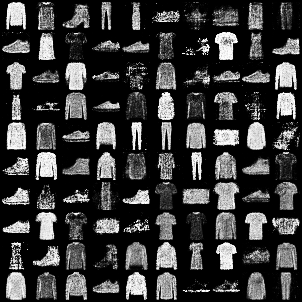

In [47]:
Image('./samples/fake_images-0320.png')

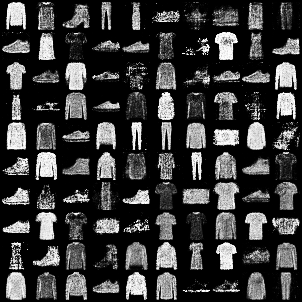

In [49]:
Image('./samples/fake_images-0330.png')

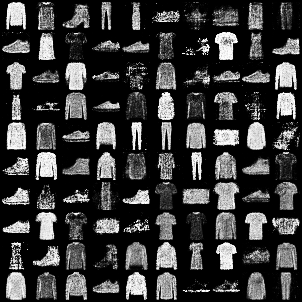

In [50]:
Image('./samples/fake_images-0340.png')

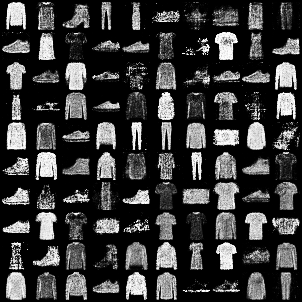

In [51]:
Image('./samples/fake_images-0350.png')

After 350 epochs, there was observed a slight decrease of losses of d_loss, g_loss indicate that both the discriminator and generator are learning and improving over the course of training. Slight decrease of D(G(z)) value and tend close to zero which means that generator is producing images that are becoming increasingly realistic to the discriminator.

##### Saving the weights without using the checkpoints.

In [52]:
torch.save(generator_new.state_dict(), 'weights/genertor_after_training_weight')

In [53]:
torch.save(discriminator_new.state_dict(), 'weights/discriminator_after_training_weight')

##### Loading the weights.

In [54]:
import torch
gen_state_dict = torch.load('weights/genertor_after_training_weight')
discriminator_state_dict = torch.load('weights/discriminator_after_training_weight')


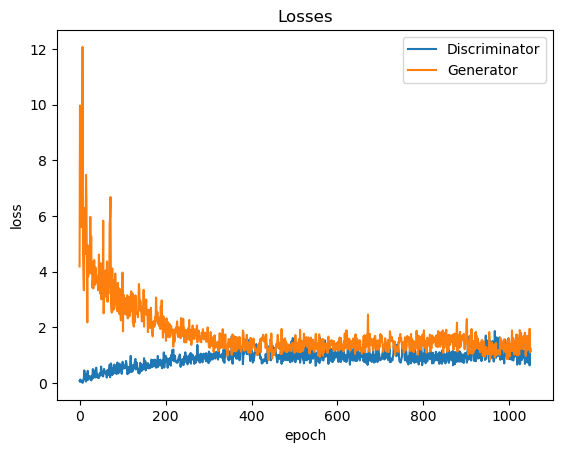

In [55]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

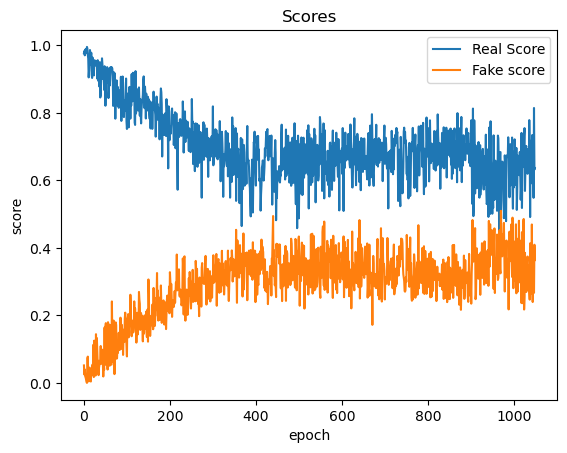

In [56]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');